## 1. Install Dependencies and MNIST Dataset

In [ ]:
import tensorflow as tf
from matplotlib import pyplot as plt

In [ ]:
 import tensorflow_datasets as tfds

In [ ]:
ds = tfds.load('fashion_mnist', split='train', shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.X1A3BR_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.X1A3BR_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


## 2. Visualize **Dataset**



In [ ]:
data_iterator = ds.as_numpy_iterator()

data_iterator.next()['image'].shape

(28, 28, 1)

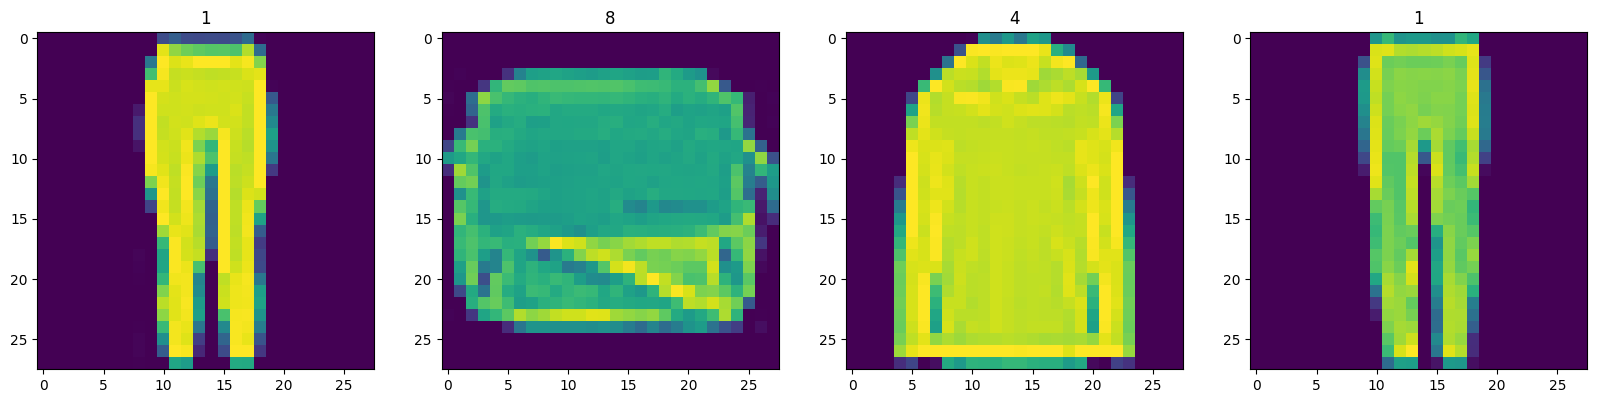

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))

for idx in range(4):
    sample = data_iterator.next()
    ax[idx].imshow(np.squeeze(sample['image']))
    ax[idx].title.set_text(sample['label'])

## 3. Create Dataset Pipeline

In [ ]:
def normalize_img(data):
 image = data['image']
 return image / 255

In [ ]:
# Reload the dataset
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(normalize_img)
# Cache the dataset for that batch
ds = ds.cache()
# Shuffle it up
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking
ds = ds.prefetch(64)

In [ ]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

## 4. Building Model

### Build Generator

In [ ]:
def build_generator():
  model = Sequential()
  model.add(Dense(7*7*128,  input_dim = 128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  model.add(UpSampling2D())
  model.add(Conv2D(128,5,padding = 'same'))
  model.add(LeakyReLU(0.2))

  model.add(UpSampling2D())
  model.add(Conv2D(128,5,padding = 'same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))




  model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
  return model

In [ ]:
generator = build_generator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Build Discriminator

In [ ]:
def build_discriminator():
    model = Sequential()

    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
discriminator = build_discriminator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 6. Build Custom Training Loop

### Custom LR Decay Callback

In [ ]:
from tensorflow.keras.callbacks import Callback  # Import Callback from tensorflow.keras.callbacks
class LrDecay(Callback):
    def __init__(self, d_optimizer, patience, min_delta, decay_rate, min_lr,history_loss):
        super().__init__()
        self.d_optimizer = d_optimizer
        self.patience = patience
        self.min_delta = min_delta
        self.decay_rate = decay_rate
        self.min_lr = min_lr
        self.history_loss = []  # Corrected: Keep internal loss history

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            return

        d_loss = logs.get("d_loss")  # Ensure d_loss is logged in training
        if d_loss is None:
            print("Warning: Discriminator loss (d_loss) not found in logs.")
            return

        self.history_loss.append(d_loss)

        # Check if we have enough history
        if len(self.history_loss) > self.patience:
            recent_losses = self.history_loss[-self.patience:]
            loss_change = recent_losses[0] - recent_losses[-1]

            if loss_change < self.min_delta:  # If improvement is too small
                current_lr = self.d_optimizer.learning_rate.numpy()  # Access the learning rate as a numpy value
                if current_lr > self.min_lr:
                    new_lr = max(current_lr * self.decay_rate, self.min_lr)
                    K.set_value(self.d_optimizer.learning_rate, new_lr)
                    print(f"Reducing learning rate: {current_lr:.6f} → {new_lr:.6f}")

                    self.history_loss = []  # Reset history after reducing LR


### Setting Losses & Optimizers

In [ ]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both
from tensorflow.keras.losses import BinaryCrossentropy
g_opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
d_opt = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5)

g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()
lr_decay_callback = LrDecay(d_optimizer=d_opt, patience=10, min_delta=0.01, decay_rate=0.7, min_lr=1e-6,history_loss = [])


In [ ]:
d_opt.learning_rate

<Variable path=adam/learning_rate, shape=(), dtype=float32, value=9.999999747378752e-06>

In [ ]:
from tensorflow.keras.models import Model

### Building Custom Subclassed Model

In [ ]:
from tensorflow.keras import saving
from tensorflow.keras.models import Model, model_from_json
import tensorflow as tf

@saving.register_keras_serializable()
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super(FashionGAN, self).__init__(*args, **kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.generator_loss_tracker = tf.keras.metrics.Mean(name="g_loss")
        self.discriminator_loss_tracker = tf.keras.metrics.Mean(name="d_loss")

    @property
    def metrics(self):
        # Return the metrics to be reset at the end of each epoch
        return [self.generator_loss_tracker, self.discriminator_loss_tracker]

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super(FashionGAN, self).compile(*args, **kwargs)
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal(shape=(128, 128)), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            y_pred_real = self.discriminator(real_images)
            y_pred_fake = self.discriminator(fake_images)
            y_real = tf.zeros_like(y_pred_real)
            y_fake = tf.ones_like(y_pred_fake)
            y_pred = tf.concat([y_pred_real, y_pred_fake], axis=0)
            y_true = tf.concat([y_real, y_fake], axis=0)

            # Add noise to the true labels
            noise_real = 0.15 * tf.random.uniform(tf.shape(y_pred_real))
            noise_fake = -0.15 * tf.random.uniform(tf.shape(y_pred_fake))
            y_true += tf.concat([noise_real, noise_fake], axis=0)
            d_loss = self.d_loss(y_true, y_pred)

        dgrad = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            y_pred = self.discriminator(self.generator(tf.random.normal(shape=(128, 128)), training=True))
            y_true = tf.zeros_like(y_pred)
            g_loss = self.g_loss(y_true, y_pred)

        ggrad = g_tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        self.generator_loss_tracker.update_state(g_loss)
        self.discriminator_loss_tracker.update_state(d_loss)

        return {"d_loss": d_loss, "g_loss": g_loss}

    def get_config(self):
        """Returns the configuration of the model for saving."""
        config = super(FashionGAN, self).get_config()
        config.update({
            "generator_json": self.generator.to_json(),  # Save generator as JSON
            "discriminator_json": self.discriminator.to_json(),  # Save discriminator as JSON
        })
        return config

    @classmethod
    def from_config(cls, config):
        """Reconstruct the model from its configuration."""
        generator_json = config.pop("generator_json")
        discriminator_json = config.pop("discriminator_json")
        generator = model_from_json(generator_json)
        discriminator = model_from_json(discriminator_json)
        return cls(generator=generator, discriminator=discriminator, **config)

    def call(self, inputs, training=False):
        # Forward pass: generate images or pass inputs to discriminator as needed
        return self.generator(inputs, training=training)


In [ ]:
fashgan = FashionGAN(generator, discriminator)

### Compile

In [ ]:
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Defining Checkpoints

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define checkpoint to save weights to Google Drive
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/fashiongan_checkpoint.keras',  # Changed the file extension to .keras
    save_weights_only=False,                        # Save weights, not the entire model
    save_best_only=False,                          # Save after every epoch
    verbose=1                                      # Print message after saving
)

In [ ]:
import json
from tensorflow.keras.callbacks import Callback

class SaveHistory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Save history to Google Drive
        with open('/content/drive/MyDrive/training_history.json', 'w') as f:
            json.dump(self.model.history.history, f)



In [ ]:
save_history = SaveHistory()


### Train Model

In [ ]:
model = fashgan  # Replace with your model initialization code


# Retry training
hist = model.fit(ds, epochs=80, callbacks=[checkpoint])


Epoch 1/80
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - d_loss: 0.5734 - g_loss: 1.1982
Epoch 1: saving model to /content/drive/MyDrive/fashiongan_checkpoint.keras


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


469/469 ━━━━━━━━━━━━━━━━━━━━ 129s 220ms/step - d_loss: 0.5737 - g_loss: 1.1972
Epoch 2/80
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - d_loss: 0.6525 - g_loss: 0.8429
Epoch 2: saving model to /content/drive/MyDrive/fashiongan_checkpoint.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 111s 197ms/step - d_loss: 0.6524 - g_loss: 0.8431
Epoch 3/80
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - d_loss: 0.6523 - g_loss: 0.8056
Epoch 3: saving model to /content/drive/MyDrive/fashiongan_checkpoint.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 197ms/step - d_loss: 0.6523 - g_loss: 0.8061
Epoch 4/80
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - d_loss: 0.6603 - g_loss: 0.7753
Epoch 4: saving model to /content/drive/MyDrive/fashiongan_checkpoint.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 92s 197ms/step - d_loss: 0.6603 - g_loss: 0.7759
Epoch 5/80
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - d_loss: 0.6657 - g_loss: 0.7762
Epoch 5: saving model to /content/drive/MyDrive/fashiongan_checkpoint.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
from tensorflow.keras.models import load_model
fashgan = load_model(
    '/content/drive/MyDrive/fashiongan_model.keras',
    custom_objects={'FashionGAN': FashionGAN}
)


In [ ]:
fashgan.fit(ds, epochs=150, initial_epoch=99, callbacks=[checkpoint])


Epoch 99/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - d_loss: 0.6907 - g_loss: 0.7112
Epoch 99: saving model to /content/drive/MyDrive/fashiongan_checkpoint.keras


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


469/469 ━━━━━━━━━━━━━━━━━━━━ 100s 164ms/step - d_loss: 0.6907 - g_loss: 0.7112
Epoch 100/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - d_loss: 0.6910 - g_loss: 0.7103
Epoch 100: saving model to /content/drive/MyDrive/fashiongan_checkpoint.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 69s 148ms/step - d_loss: 0.6910 - g_loss: 0.7103
Epoch 101/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - d_loss: 0.6916 - g_loss: 0.7107
Epoch 101: saving model to /content/drive/MyDrive/fashiongan_checkpoint.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 69s 148ms/step - d_loss: 0.6916 - g_loss: 0.7107
Epoch 102/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - d_loss: 0.6910 - g_loss: 0.7108
Epoch 102: saving model to /content/drive/MyDrive/fashiongan_checkpoint.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 70s 148ms/step - d_loss: 0.6910 - g_loss: 0.7108
Epoch 103/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - d_loss: 0.6912 - g_loss: 0.7095
Epoch 103: saving model to /content/drive/MyDrive/fashiongan_checkpoint.keras
469/469 ━━━

In [ ]:
fashgan.fit(ds, epochs=170, initial_epoch=142, callbacks=[checkpoint])


Epoch 143/170
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - d_loss: 0.6938 - g_loss: 0.6924
Epoch 143: saving model to /content/drive/MyDrive/fashiongan_checkpoint.keras


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


469/469 ━━━━━━━━━━━━━━━━━━━━ 102s 160ms/step - d_loss: 0.6938 - g_loss: 0.6924
Epoch 144/170
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - d_loss: 0.6941 - g_loss: 0.6925
Epoch 144: saving model to /content/drive/MyDrive/fashiongan_checkpoint.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 68s 145ms/step - d_loss: 0.6941 - g_loss: 0.6925
Epoch 145/170
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - d_loss: 0.6942 - g_loss: 0.6931
Epoch 145: saving model to /content/drive/MyDrive/fashiongan_checkpoint.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 146ms/step - d_loss: 0.6942 - g_loss: 0.6931
Epoch 146/170
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - d_loss: 0.6942 - g_loss: 0.6930
Epoch 146: saving model to /content/drive/MyDrive/fashiongan_checkpoint.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 68s 144ms/step - d_loss: 0.6942 - g_loss: 0.6930
Epoch 147/170
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - d_loss: 0.6941 - g_loss: 0.6926
Epoch 147: saving model to /content/drive/MyDrive/fashiongan_checkpoint.keras
469/469 ━━━

In [ ]:
fashgan.fit(ds, epochs=220, initial_epoch=170, callbacks=[checkpoint])


Epoch 171/220
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - d_loss: 0.6932 - g_loss: 0.6947
Epoch 171: saving model to /content/drive/MyDrive/fashiongan_checkpoint.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 84s 156ms/step - d_loss: 0.6932 - g_loss: 0.6947
Epoch 172/220
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - d_loss: 0.6932 - g_loss: 0.6929
Epoch 172: saving model to /content/drive/MyDrive/fashiongan_checkpoint.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 70s 145ms/step - d_loss: 0.6932 - g_loss: 0.6929
Epoch 173/220
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - d_loss: 0.6932 - g_loss: 0.6935
Epoch 173: saving model to /content/drive/MyDrive/fashiongan_checkpoint.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 144ms/step - d_loss: 0.6932 - g_loss: 0.6935
Epoch 174/220
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - d_loss: 0.6932 - g_loss: 0.6934
Epoch 174: saving model to /content/drive/MyDrive/fashiongan_checkpoint.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 67s 143ms/step - d_loss: 0.6932 - g_loss: 0.6934
Epoch 175/22

## Generating Images Using Trained Generator

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


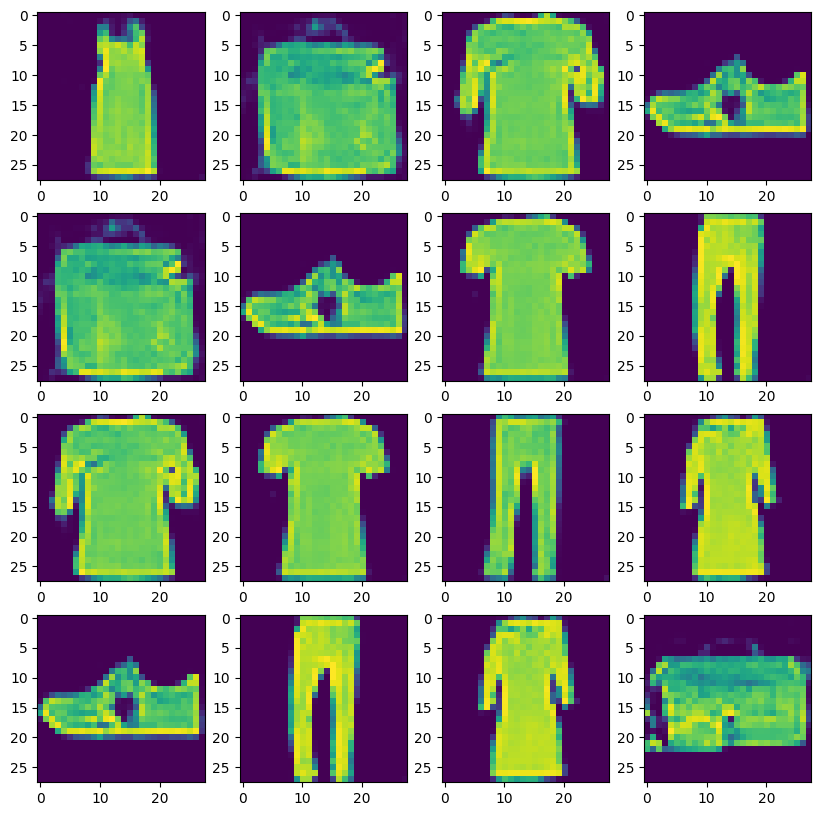

In [ ]:
imgs = fashgan.generator.predict(tf.random.normal((16, 128, 1)))
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

In [ ]:
import json

# Load generator model JSON
with open('/content/drive/MyDrive/generator_model.json', 'r') as f:
    generator_json = f.read()
    print(generator_json)  # Prints the architecture details

# Load discriminator model JSON
with open('/content/drive/MyDrive/discriminator_model.json', 'r') as f:
    discriminator_json = f.read()
    print(discriminator_json)  # Prints the architecture details


{"module": "keras", "class_name": "Sequential", "config": {"name": "sequential", "trainable": true, "dtype": {"module": "keras", "class_name": "DTypePolicy", "config": {"name": "float32"}, "registered_name": null}, "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_shape": [null, 128], "dtype": "float32", "sparse": false, "name": "input_layer"}, "registered_name": null}, {"module": "keras.layers", "class_name": "Dense", "config": {"name": "dense", "trainable": true, "dtype": {"module": "keras", "class_name": "DTypePolicy", "config": {"name": "float32"}, "registered_name": null}, "units": 6272, "activation": "linear", "use_bias": true, "kernel_initializer": {"module": "keras.initializers", "class_name": "GlorotUniform", "config": {"seed": null}, "registered_name": null}, "bias_initializer": {"module": "keras.initializers", "class_name": "Zeros", "config": {}, "registered_name": null}, "kernel_regularizer": null, "bias_regularizer": null, "kernel_constrai